In [133]:
import tensorflow as tf
print(tf.__version__)
import tensorflow_hub as hub
from tensorflow.keras import datasets, layers, models
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pylab as plt

2.3.0


In [134]:
data_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

In [135]:
pixels =224
BATCH_SIZE = 32 
IMAGE_SIZE = (pixels, pixels)

In [136]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = False 
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 731 images belonging to 5 classes.
Found 2939 images belonging to 5 classes.


In [137]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [138]:
# Plain text name in alphabetical order. https://www.cs.toronto.edu/~kriz/cifar.html
CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 
               'deer','dog', 'frog', 'horse', 'ship', 'truck']

In [139]:
unique, counts = np.unique(train_labels, return_counts=True)

These are distributions of training sample numbers across ten classes:

In [140]:
print(np.asarray((unique, counts)))

[[   0    1    2    3    4    5    6    7    8    9]
 [5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]]


And these are distributions of test sample numbers across ten classes:

In [141]:
unique, counts = np.unique(test_labels, return_counts=True)
print(np.asarray((unique, counts)))

[[   0    1    2    3    4    5    6    7    8    9]
 [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]]


Let's use half of test data as the validation data.

In [142]:
validation_dataset = tf.data.Dataset.from_tensor_slices((test_images[:500], test_labels[:500]))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images[500:], test_labels[500:]))

Now the datasets are built for validation and test data. Next, we will keep all training data for training.

In [143]:
# Create an instance of dataset from raw numpy images and labels.
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

In [144]:
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset#transformations_2
train_dataset_size = len(list(train_dataset.as_numpy_iterator()))
print('Training data sample size: ', train_dataset_size)

Training data sample size:  50000


Dataset for training data is now built. We may examine some of training data at random. Let's create a list of indices for training data, then randomly select 25 images from training data. 


There are 50,000 images in training data. These images are indexed from 0 to 49999. In order to randomly select a finite number of indices from this range, you may use Python's `random` library. This library takes a Python list as an input, and randomly selects a finite number of samples from this list:

`selected_elements = random.sample(a_list, 25)`

In the code above, you randomly selected 25 elements from `a_list`, and store the results in `selected_elements`. And if `a_list` corresponds to the image indices, then `selected_elements` contains 25 indices drawn at random from `a_list`. you will use `selected_elements` to access training images and display these images.

Now you know how to randomly select indices to training images, you need to create a list that holds indices for training images. 50,000 Training images are indexed from 0 to 49,999. You may use Python's `range` function to create an object that holds integers in this range:

`range(len(train_labels))`

The code above creates a range object that holds integers from 0 and up to how many training labels there are, which is `len(train_labels)`, or length of `training_labels`.

Then we may convert it to a Python list:

`list(range(len(train_labels)))`

This list is ready to serve as the input to Python's `random.sample` function, which is what you will use to randomly sample finite number of element from a list.

In [145]:
len(train_labels)

50000

In [146]:
train_idx = list(range(len(train_labels)))

In [147]:
import random
random.seed(2)
random_sel = random.sample(train_idx, 25)
random_sel

[3706,
 6002,
 5562,
 23662,
 11081,
 48232,
 43891,
 20194,
 16487,
 39711,
 13907,
 39767,
 2341,
 38089,
 44646,
 10379,
 28224,
 41842,
 25790,
 47383,
 33362,
 24383,
 35663,
 29153,
 32903]

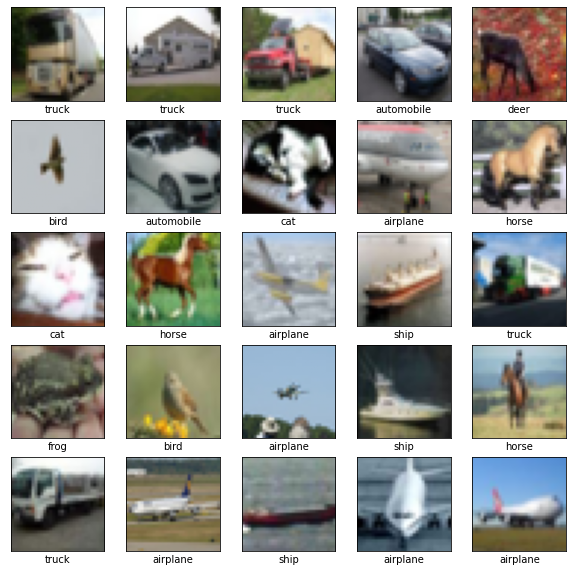

In [148]:
plt.figure(figsize=(10,10))
for i in range(len(random_sel)):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[random_sel[i]], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(CLASS_NAMES[train_labels[random_sel[i]][0]])
plt.show()

Above figures are selected at random. Your results will vary.

In [149]:
TRAIN_BATCH_SIZE = 200
train_dataset = train_dataset.shuffle(50000).batch(TRAIN_BATCH_SIZE)

In [150]:
validation_dataset = validation_dataset.batch(500)
test_dataset = test_dataset.batch(500)

In [151]:
STEPS_PER_EPOCH = train_dataset_size / TRAIN_BATCH_SIZE
VALIDATION_STEPS = 1

In [152]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', 
                           kernel_initializer='glorot_uniform', padding='same', input_shape = (32,32,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', 
                           kernel_initializer='glorot_uniform', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_initializer='glorot_uniform'),
    tf.keras.layers.Dense(10, activation='softmax', name = 'custom_class')
])
model.build([None, 32, 32, 3])

In [153]:
model.compile(
          loss='sparse_categorical_crossentropy',
          optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9),
          metrics=['accuracy'])

In [154]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               1048832   
_________________________________________________________________
custom_class (Dense)         (None, 10)               

In [155]:
hist = model.fit(
    train_dataset,
    epochs=5, steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_dataset,
    validation_steps=VALIDATION_STEPS).history

Epoch 1/5
250/250 [==============================] - 73s 291ms/step - loss: 1.8419 - accuracy: 0.3239 - val_loss: 1.4267 - val_accuracy: 0.4520
Epoch 2/5
250/250 [==============================] - 72s 289ms/step - loss: 1.3386 - accuracy: 0.5255 - val_loss: 1.3181 - val_accuracy: 0.5020
Epoch 3/5
250/250 [==============================] - 72s 289ms/step - loss: 1.1898 - accuracy: 0.5781 - val_loss: 1.2002 - val_accuracy: 0.5520
Epoch 4/5
250/250 [==============================] - 72s 290ms/step - loss: 1.0525 - accuracy: 0.6288 - val_loss: 1.1291 - val_accuracy: 0.6280
Epoch 5/5
250/250 [==============================] - 73s 292ms/step - loss: 0.9380 - accuracy: 0.6701 - val_loss: 1.1946 - val_accuracy: 0.5940


In [173]:
class myModel(tf.keras.Model):
  def __init__(self, input_dim):
    super(myModel, self).__init__()
    self.conv2d_initial = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', 
                           kernel_initializer='glorot_uniform', padding='same', input_shape = (input_dim,input_dim,3))
    self.cov2d_mid = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', 
                           kernel_initializer='glorot_uniform', padding='same')
    self.maxpool2d = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
    self.flatten = tf.keras.layers.Flatten()
    self.dense = tf.keras.layers.Dense(256, activation='relu', kernel_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(10, activation='softmax', name = 'custom_class')

  def call(self, input_dim):
    x = self.conv2d_initial(input_dim)
    x = self.maxpool2d(x)
    x = self.cov2d_mid(x)
    x = self.maxpool2d(x)
    x = self.flatten(x)
    x = self.dense(x)
    x = self.fc(x)

    return x


## Reference
https://towardsdatascience.com/3-ways-to-create-a-machine-learning-model-with-keras-and-tensorflow-2-0-de09323af4d3

In [174]:
mdl = myModel(32)

In [175]:
mdl.compile(loss='sparse_categorical_crossentropy',
          optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9),
          metrics=['accuracy'])


In [177]:
mdl_hist = mdl.fit(
    train_dataset,
    epochs=5, steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_dataset,
    validation_steps=VALIDATION_STEPS).history

Epoch 1/5
250/250 [==============================] - 78s 314ms/step - loss: 0.7169 - accuracy: 0.7494 - val_loss: 1.1197 - val_accuracy: 0.6240
Epoch 2/5
250/250 [==============================] - 73s 294ms/step - loss: 0.5997 - accuracy: 0.7894 - val_loss: 1.2109 - val_accuracy: 0.6300
Epoch 3/5
250/250 [==============================] - 72s 289ms/step - loss: 0.5113 - accuracy: 0.8200 - val_loss: 1.3374 - val_accuracy: 0.6280
Epoch 4/5
250/250 [==============================] - 71s 286ms/step - loss: 0.4400 - accuracy: 0.8459 - val_loss: 1.5777 - val_accuracy: 0.5980
Epoch 5/5
250/250 [==============================] - 73s 292ms/step - loss: 0.3851 - accuracy: 0.8673 - val_loss: 1.7335 - val_accuracy: 0.6140
